<a href="https://colab.research.google.com/github/McGKoe/Rad/blob/main/Project%20Description.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Develop NLP Models for Medical Data Extraction in Collaboration with RadAI
The purpose of this project was to utilize natural language processing and machine learning to perform radiology report field identification.

We will be building a logistic regression model using both TSNE and Word2Vec with open_ave_data.csv

## 1. Getting Started

In [22]:
import io
import os
from google.colab import files
from collections import  Counter
import glob
import pandas as pd
from sklearn.manifold import TSNE
import numpy as np
import matplotlib.pyplot as plt
import sklearn as sk
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import feature_extraction
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from scipy.sparse import hstack
from scipy.linalg import dft
from time import time


from gensim.models import Word2Vec, FastText
import re

from sklearn.decomposition import PCA

from matplotlib import pyplot as plt
import plotly.graph_objects as go

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


In [23]:
import warnings
warnings.filterwarnings('ignore')

## 2. Data Collection
Using the radiology report data in open_ave_data.csv

In [24]:
temp = pd.read_csv('open_ave_data.csv', engine = 'python', nrows = 957, index_col = 0)

## 2.1 Data Cleaning
Removing unwanted data from the DataFrame

In [25]:
# remove duplicates
corpus = temp.drop_duplicates()
corpus.dropna(inplace=True)

#convert to lowercaose
corpus = corpus.apply(lambda x: x.astype(str).str.lower())

#remove label from each cell
corpus['findings'] = corpus['findings'].str.replace('findings', '')
corpus['clinicaldata'] = corpus['clinicaldata'].str.replace('clinical', '')
corpus['clinicaldata'] = corpus['clinicaldata'].str.replace('clinical data', '')
corpus['clinicaldata'] = corpus['clinicaldata'].str.replace('indication', '')
corpus['clinicaldata'] = corpus['clinicaldata'].str.replace('history', '')
corpus['clinicaldata'] = corpus['clinicaldata'].str.replace('data', '')
corpus['clinicaldata'] = corpus['clinicaldata'].str.replace('information', '')
corpus['ExamName'] = corpus['ExamName'].str.replace('exam', '')
corpus['impression'] = corpus['impression'].str.replace('impression', '')

#remove punctuation
corpus = corpus.replace(to_replace='[.!"#$%&\'()*+,/:;<=>?@[\\]^_`{|}~]',value=' ',regex=True)
corpus = corpus.replace(to_replace='-',value=' ',regex=True)

#remove newline
corpus = corpus.replace(to_replace='\s+',value=' ',regex=True)

#remove double whitespace
corpus = corpus.replace(to_replace='  ',value='',regex=True)

## 3. Create TF-IDF Matrix
Create and plot the TF-IDF Document-Term Matrix.

TF-IDF stands for “Term Frequency — Inverse Document Frequency”. This is a technique to calculate the weight of each word, or the importance of the word in the document and corpus.

Term Frequency (TF): The number of times a word appears in a document divided by the total number of words in the document. Each document has its own term frequency.

Inverse Data Frequency (IDF): The log of the number of documents divided by the number of documents that contain the word *w*. Inverse Data Frequency determines the weight of rare words across all documents in the corpus.

Lastly, the TF-IDF is simply the TF multiplied by IDF.

TF-IDF = Term Frequency (TF) * Inverse Document Frequency (IDF)

We can implement this easily using Sklearn.

In [26]:
# create lists of each of the fields in the csv file
findings = corpus['findings'].tolist()
clinicaldata = corpus['clinicaldata'].tolist()
examname = corpus['ExamName'].tolist()
impression = corpus['impression'].tolist()

In [27]:
# create list of list of words in the csv file
corpus = findings + clinicaldata + examname + impression

## Tf-Idf (advanced variant of BoW)
vectoriser = feature_extraction.text.TfidfVectorizer(max_features=1000)

# fit_transform is a combination of the fit method and the transform method
# use fit_transform method to learn vocabulary and idf, return document-term matrix
X = vectoriser.fit_transform(corpus)

# convert document-term matrix to ndarray
X.toarray

# convert X to a format that can be plotted on a 2d graph
X_embedded = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=4).fit_transform(X)

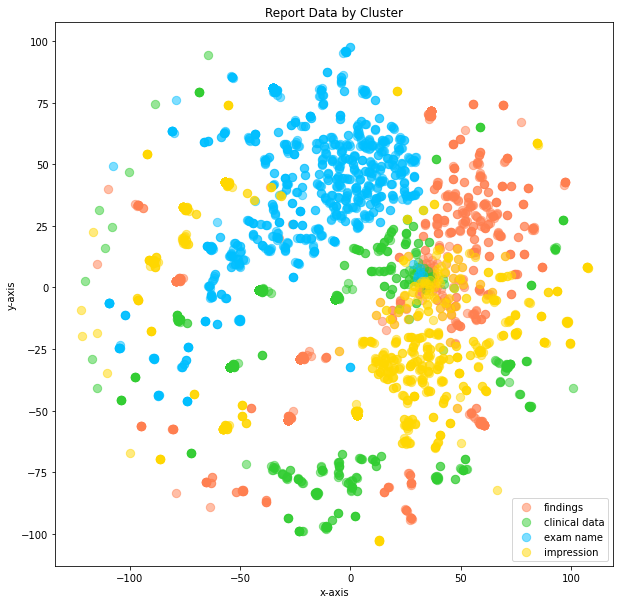

In [28]:
# plot the embedded matrix

import matplotlib.pyplot as plt
import numpy as np
plt.figure(figsize=(10, 10))

# x and y values for the first scatter plot
x1 = X_embedded[0:949, 1]
y1 = X_embedded[0:949, 0]

# x and y values for the second scatter plot
x2 = X_embedded[950:1899, 1]
y2 = X_embedded[950:1899, 0]

# third 
x3 = X_embedded[1900:2849, 1]
y3 = X_embedded[1900:2849, 0]

# fourth
x4 = X_embedded[2850:3800, 1]
y4 = X_embedded[2850:3800, 0]

# first scatter plot
plt.scatter(x1, y1, c ="coral", marker ="o", s = 70, alpha=0.5)

# second
plt.scatter(x2, y2, c ="limegreen", marker ="o", s = 70, alpha=0.5)

# third
plt.scatter(x3, y3, c ="deepskyblue", marker ="o", s = 70, alpha=0.5)

# fourth
plt.scatter(x4, y4, c ="gold", marker ="o", s = 70, alpha=0.5)


plt.title('Report Data by Cluster')
plt.legend(["findings", "clinical data", "exam name", "impression"], loc ="lower right")

plt.xlabel('x-axis')
plt.ylabel('y-axis')

plt.show()

## 4. Logistic Regression for TF-IDF
Train a logistic regression model using the tf-idf matrix

In [114]:
#create the labels for each of the 3800 rows in the tf-idf matrix
height = 3800
y = pd.DataFrame(0, index=range(height), columns=range(1))

y.loc[0:949,""]= 'findings'
y.loc[950:1899,""]= 'clinicaldata'
y.loc[1900:2849,""]= 'examname'
y.loc[2850:3799,""]= 'impression'

y.rename(columns = {'':'y'}, inplace = True)

y.drop(columns=[0], inplace = True)

In [115]:
# split into train and test data

df_X = pd.DataFrame (corpus, columns = ['X'])

df_all = pd.concat([df_X, y], axis=1)

# select random subset to turn into training and testing data
msk = np.random.rand(len(df_all)) < 0.66

#train material
train = df_all[msk]

#test material
test = df_all[~msk]

#training text
train_text = train['X']

#testing text
test_text = test['X']

#labels for the training data
train_y = train['y']

#all_text = pd.concat([train_text, test_text])

In [122]:
# vectorize the words in the training text
word_vectorizer = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', sublinear_tf=True, strip_accents='unicode', 
                                  stop_words='english', ngram_range=(1, 1), max_features=100)
word_vectorizer.fit(train_text)

train_word_features = word_vectorizer.transform(train_text)

train_features = hstack([train_word_features])

In [117]:
# split into training and testing data
X_train, X_test, y_train, y_test = train_test_split(train_features, train_y,test_size=0.3 ,random_state=1234)

In [118]:
print(X_train)

  (0, 38)	1.0
  (1, 81)	0.7071067811865475
  (1, 27)	0.7071067811865475
  (2, 98)	0.5751291677605728
  (2, 94)	0.30336119998887917
  (2, 89)	0.3387638758977514
  (2, 75)	0.4976783032588506
  (2, 33)	0.29138688539187246
  (2, 31)	0.3603435147273863
  (3, 69)	0.8827175036079665
  (3, 31)	0.4699040421449037
  (4, 99)	0.3104991996148795
  (4, 95)	0.15363573610409126
  (4, 75)	0.384144507007495
  (4, 40)	0.4884735066427737
  (4, 33)	0.10717258586746159
  (4, 31)	0.1867926234458236
  (4, 22)	0.36029402814169836
  (4, 15)	0.41158305848986065
  (4, 1)	0.38499752023697953
  (5, 95)	0.41963378486259206
  (5, 68)	0.4638935953560151
  (5, 33)	0.29272641236674124
  (5, 31)	0.362000040406458
  (5, 14)	0.6260810147562254
  :	:
  (1725, 66)	0.2713745215756431
  (1725, 62)	0.2566644769219231
  (1725, 59)	0.21739480786057222
  (1725, 56)	0.309965943777277
  (1725, 48)	0.3012366792196162
  (1725, 43)	0.22932037274009456
  (1725, 36)	0.3054870683624672
  (1725, 29)	0.2739892235596807
  (1726, 87)	0.370058

In [119]:
print(y_train)

1190    clinicaldata
1644    clinicaldata
2473        examname
1385    clinicaldata
1993        examname
            ...     
412         findings
3122      impression
994     clinicaldata
1998        examname
1080    clinicaldata
Name: y, Length: 1730, dtype: object


In [105]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# train logistic regression model
lr=LogisticRegression(C=1, solver ='saga')
lr.fit(X_train, y_train)
lr_preds=lr.predict(X_test)

# print confusioin matrix
print('confustion matrix:', '\n', 'fin. cli. exa. imp.', '\n', confusion_matrix(y_test, lr_preds, labels=["findings", "clinicaldata", "examname", "impression"]), '\n\n')

# print classification report
print('classification report:', '\n', classification_report(y_test, lr_preds), '\n\n')

#print accuracy score
print("Accuracy Score: %.3f" % accuracy_score(y_test, lr_preds))

confustion matrix: 
 fin. cli. exa. imp. 
 [[203   0   0   4]
 [  4 175   0   3]
 [  0   0 176   0]
 [  3   0   0 172]] 


classification report: 
               precision    recall  f1-score   support

clinicaldata       1.00      0.96      0.98       182
    examname       1.00      1.00      1.00       176
    findings       0.97      0.98      0.97       207
  impression       0.96      0.98      0.97       175

    accuracy                           0.98       740
   macro avg       0.98      0.98      0.98       740
weighted avg       0.98      0.98      0.98       740
 


Accuracy Score: 0.981


In [ ]:
# precision: measure of a classifier’s exactness
# per class, ratio of true positives to the sum of true and false positives
# “for all instances classified positive, what percent was correct?”

In [ ]:
# recall: measure of the classifier’s completeness
# can a classifier correctly find all positive instances?
# per class, ratio of true positives to the sum of true positives and false negatives
# “for all instances that were actually positive, what percent was classified correctly?”

In [ ]:
# f1 score: weighted harmonic mean of precision and recall 
# best score is 1.0 and worst is 0.0
# F1 typically lower than accuracy 
# weighted average of F1 better for comparison of classifier models (not accuracy)

In [ ]:
# support: number of actual occurrences of the class in the specified dataset
# imbalanced support in training data => possible structural weaknesses in classifier reported scores
# could indicate the need for stratified sampling or rebalancing
# doesn’t change between models, does diagnose evaluation process

As you can see, this model is very accurate. It can predict the section of the report that a word belongs to with about 98% accuracy.

## 4.1 Visual Representation of Confusion Matrix

<Figure size 720x720 with 0 Axes>

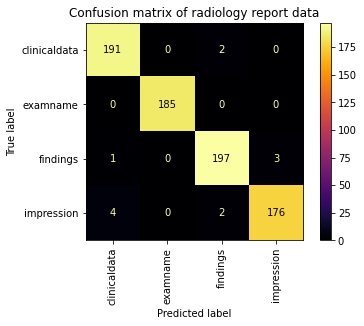

In [34]:
#print the confusion matrix in an easy-to-read format

cm = confusion_matrix(y_test, lr_preds, labels = lr.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = lr.classes_)

plt.figure(figsize = (10, 10))
disp.plot(cmap = 'inferno', xticks_rotation = 'vertical')
plt.title('Confusion matrix of radiology report data')
plt.show()

In [ ]:
test['y'].value_counts()

impression      313
clinicaldata    310
examname        307
findings        300
Name: y, dtype: int64

## 5. Word2Vec Model Training
We will now create vectors that take into account the context of a word using Word2Vec

In [ ]:
## Word2Vec Model Training

In [74]:
from gensim.models import Word2Vec, FastText
import pandas as pd
import re

from sklearn.decomposition import PCA

from matplotlib import pyplot as plt
import plotly.graph_objects as go

import numpy as np

import warnings
warnings.filterwarnings('ignore')

In [75]:
#converts a sentece into a list of words
def sentence_to_words(temp):
  return list(temp.split())

In [76]:
# creating the corpus of sentences split into words
corpus = []

#for each sentence in the list, convert to a list of words and add to the corpus

#sentences in findings
for i in findings:
  corpus.append(sentence_to_words(i))

#sentences in examname
for i in examname:
  corpus.append(sentence_to_words(i))

#sentences in clinicaldata
for i in clinicaldata:
  corpus.append(sentence_to_words(i))

#sentences in impression
for i in impression:
  corpus.append(sentence_to_words(i))

In [77]:
#generate vectors from corpus
model = Word2Vec(corpus, min_count=1, vector_size = 1000)

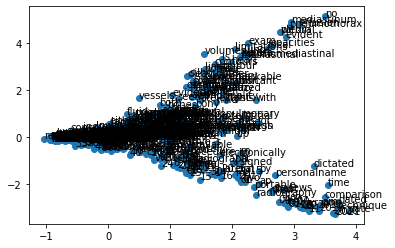

In [78]:
# X is the vectors created by the Word2Vec model
X = model.wv.vectors

# convert to form that can be plotted
pca = PCA(n_components=2)
result = pca.fit_transform(X)

# create a scatter plot of the projection
plt.scatter(result[:, 0], result[:, 1])
words = list(model.wv.key_to_index)

for i, word in enumerate(words):
   plt.annotate(word, xy=(result[i, 0], result[i, 1]))

plt.show()

## 6. Generate Linear Regression Model for Word2Vec Vectors
We will create and Linear Regression model using the Word2Vec vectors and compare the resulting confusion matrix to the one generated by the tf-odf embeddings.

In [152]:
## Generate the linear Regression model for the word vectors

In [153]:
#gets the sentence vectors from the model
def get_sentence_vectors(text):
  tokens = text.split()
  vectors = []
  for token in tokens:
    if token in model.wv.index_to_key:
      vectors.append(model.wv[token])
  if len(vectors) > 0:
     return np.mean(vectors, axis=0)
  else:
    return np.zeros((model.vector_size,))

In [154]:
# corpus of the words in the doc
corpus = findings + clinicaldata + examname + impression

# array of sentence vectors
X = np.array([get_sentence_vectors(text) for text in corpus])

# create labels in y
height = 3800
y = pd.DataFrame(0, index=range(height), columns=range(1))
y.loc[0:949,""]= 'findings'
y.loc[950:1899,""]= 'clinicaldata'
y.loc[1900:2849,""]= 'examname'
y.loc[2850:3799,""]= 'impression'

y.rename(columns = {'':'y'}, inplace = True)
y.drop(columns=[0], inplace = True)

In [155]:
# generate traing an test data from the vectora and the labels
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.3 ,random_state=1234)

In [156]:
# perform logistic regression on the training data
lr = LogisticRegression(C=1, solver ='saga')
lr.fit(X_train, y_train)

# use the trained logistic regression model on the test data
lr_preds=lr.predict(X_test)

#prints confusion matrix
print('confustion matrix:', '\n', 'fin. cli. exa. imp.', '\n', confusion_matrix(y_test, lr_preds, labels=["findings", "clinicaldata", "examname", "impression"]), '\n\n')

#prints classification report
print('classification report:', '\n', classification_report(y_test, lr_preds), '\n\n')

#prints accuracy score
print("Accuracy Score: %.3f" % accuracy_score(y_test, lr_preds))

confustion matrix: 
 fin. cli. exa. imp. 
 [[266   2   1  11]
 [  2 274   0   2]
 [  0  13 281  10]
 [ 17  14   0 247]] 


classification report: 
               precision    recall  f1-score   support

clinicaldata       0.90      0.99      0.94       278
    examname       1.00      0.92      0.96       304
    findings       0.93      0.95      0.94       280
  impression       0.91      0.89      0.90       278

    accuracy                           0.94      1140
   macro avg       0.94      0.94      0.94      1140
weighted avg       0.94      0.94      0.94      1140
 


Accuracy Score: 0.937


This model is very accurate, with an accuracy score of about 94%. It is less accurate than the tf-idf matrix.

## 6.1 Visual Representation of Confusion Matrix

<Figure size 720x720 with 0 Axes>

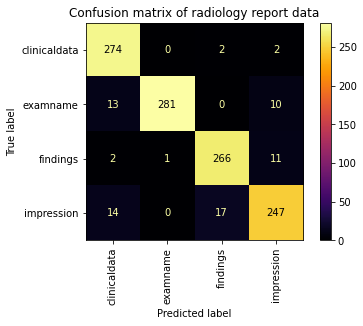

In [157]:
# prints the confusion matrix in a more readable format
cm = confusion_matrix(y_test, lr_preds, labels=lr.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=lr.classes_)
plt.figure(figsize=(10, 10))
disp.plot(cmap='inferno', xticks_rotation='vertical')
plt.title('Confusion matrix of radiology report data')
plt.show()

# Conclusions
TF-IDF and Word2Vec are both excellent tools to use to predict the section of radiology report that a token belongs to. 

The two algorithms accomplish their tasks in different ways. Word2Vec using the context of the sentences that contain words to vectorize them, while tf-idf measures the weight or importance of each word in the corpus
